In [72]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os

print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))


import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
from scipy.spatial.distance import correlation as Dcorr
import bambi as bmb
import arviz as az
import json
import pickle 
import bammm.bammm as mm
from scipy.stats import zscore as zscore_sc
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg

# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))
#sys.path.insert(1, os.path.join(root_dir, "covid-fear", "scripts", "lib", "hoeffding"))

##### VERY IMPORTANT ####
df["state_severity"] = df["deaths7_norm"]
df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]

tdf = df.loc[df["sess_str"]=="sess0",:]
tdf = tdf.loc[:,["PROLIFICID", "q7_worry_infected", "q8_prob_inf_me" ]]
tdf = tdf.rename(columns={"q7_worry_infected": "worry_infected_sess1", 
                          "q8_prob_inf_me": "prob_infected_sess1"  }).set_index("PROLIFICID")
tdf = tdf.loc[df.loc[df["sess_str"]=="sess19","PROLIFICID"],:]
#df = df.set_index("PROLIFICID")
#df = df.join(tdf, how="left")
#df2.prob_infectes_sess1
##df["memory_worry_infected_baselined"] = df["q7_worry_infected"] - df["worry_infected_sess1"]
#df["memory_prob_infected_baselined"] = df["q8_prob_inf_me"] - df["prob_infected_sess1"]

##### VERY IMPORTANT ####
df = df.rename(columns={
                        "cases14_std_unsmooth": "cases", 
                        "q7_period_rel_danger": "perceived_danger", 
                        "q7_period_rel_safety": "perceived_safety", 
                        "q7_worry_econ_impact": "econ_worry", 
                        "worryhealth": "health_worry", 
                        "prob_est": "ProbEst", 
                        "covid_worry": "CovidWorry", 
                        "q7_avoid": "Avoid", 
                        "avoid_anx": "ExposureAnx",
                        "q6_apply_soc_dist": "SocialDist", 
                        "q6_media_freq_num": "InfSeek",
                        "q7_memory_initial_worry": "MemWorry",
                        "q8_memory_prob_infected": "MemProb",
                        "memory_worry_infected_baselined": "MemWorryBlnd", 
                        "memory_prob_infected_baselined": "MemProbBlnd" })

# Create column with appropriate dates
df["Session"] = df["session"] +1
df["date"] = pd.to_datetime( df["submitdate"]).dt.strftime("%B '%y")
months = df.groupby(by="Session")["date"].apply(lambda x: np.array(x.reset_index().iloc[0,1])).reset_index()
months["session"] = months["Session"]-1

# normalize within participant
#df["econ_worry_norm"]= df.groupby(by="PROLIFICID")["econ_worry"].apply(normalize)
#sdf["health_worry_norm"]= df.groupby(by="PROLIFICID")["health_worry"].apply(normalize)
columns = ["deaths","perceived_danger", "Avoid", "InfSeek","ProbEst" ,"MemWorryBlnd", "MemProbBlnd" ]#,  "econ_worry", "health_worry"]
#tdf = df.loc[:,["Session", "PROLIFICID"]+columns]
for c in columns: 
    df[c+"_norm"] = df.groupby(by="Session")[c].apply(normalize)
#tdf = tdf.melt(id_vars = ["Session", "PROLIFICID"], value_vars=columns)

df["diff_danger_prob"] = df["perceived_danger_norm"] - df["ProbEst_norm"]


/data/drive/postdoc/Project4_covid


In [73]:
#tdf= df.loc[df.session==3,["MemWorry", "q7_worry_infected","TF2_PhysiolAnx"]]
#mod = smf.ols(formula='MemWorry ~ q7_worry_infected  + TF2_PhysiolAnx', data=tdf)
#tdf

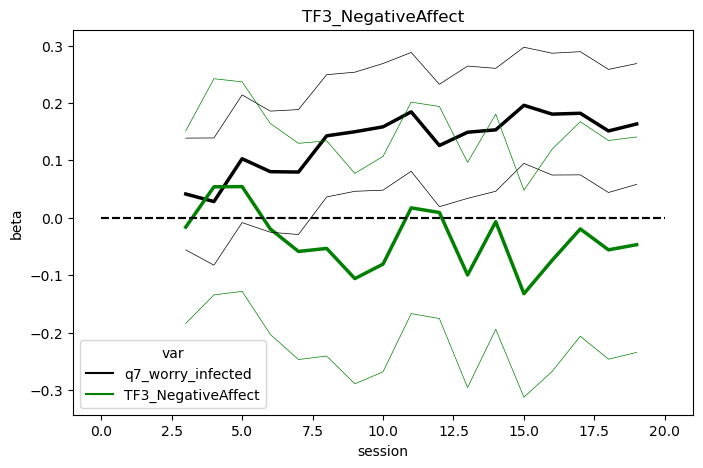

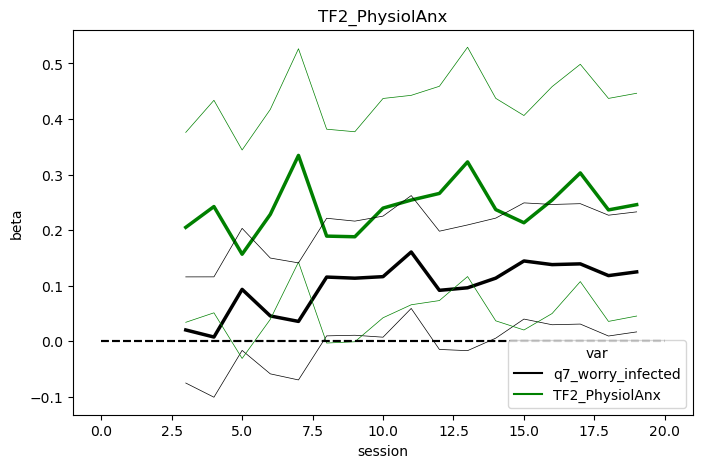

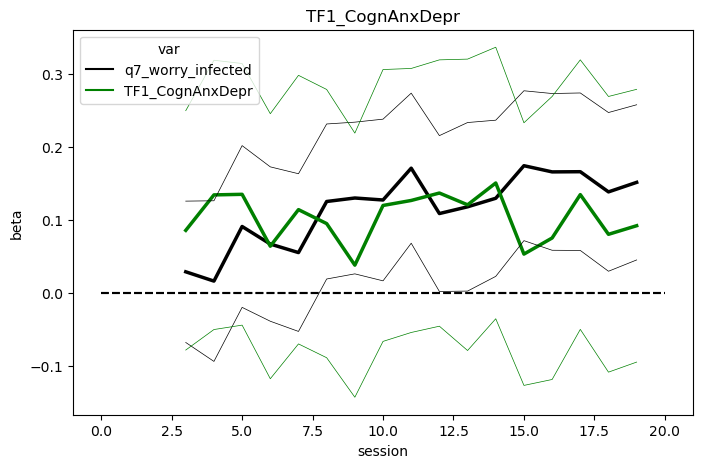

In [74]:
## Regressing current worry out Somatic anx
for tt in ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr"]: 
    regdf = pd.DataFrame()
    df["resid_worry"] = np.nan
    for sess in np.arange(3,20):
        tdf= df.loc[df.session==sess,:]
        mod = smf.ols(formula='MemWorryBlnd ~ q7_worry_infected  + '+tt, data=tdf)
        res = mod.fit()
        cdf = res.conf_int(alpha=0.05)
        cdf.columns = ["CI5", "CI95"]
        cdf["beta"] = res.params
        cdf["session"] = sess
        regdf = pd.concat([regdf, cdf])
    regdf["var"]=regdf.index
    regdf = regdf.loc[~regdf["var"].isin(["Intercept"]),:]
    f, ax = plt.subplots(1,1,figsize=(8,5))
    ax=sns.lineplot(data=regdf, x="session", y="beta", hue="var", ax=ax, linewidth=2.5, palette=["black",  "green", "dodgerblue"])
    ax=sns.lineplot(data=regdf, x="session", y="CI5", hue="var", ax=ax, linewidth=0.5, palette=["black",  "green", "dodgerblue"], legend=False)
    ax=sns.lineplot(data=regdf, x="session", y="CI95", hue="var", ax=ax, linewidth=0.5, palette=["black",  "green", "dodgerblue"], legend=False)
    ax.set_title(tt)
    #ax.set_ylim([-0.25, 0.3])
    ax.hlines( [0, 0], 0, 20,linestyles='dashed', colors=['black'])


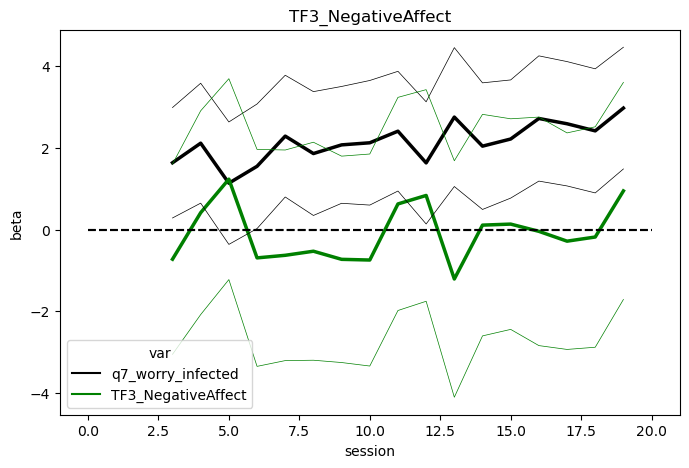

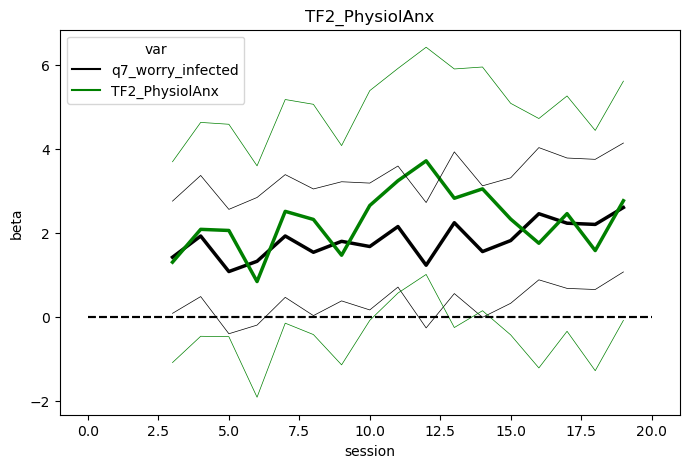

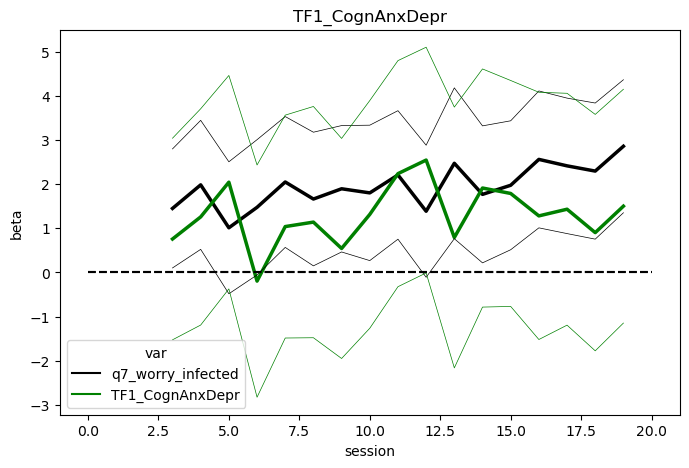

In [75]:
## Regressing current worry out Somatic anx
for tt in ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr"]: 
    regdf = pd.DataFrame()
    df["resid_worry"] = np.nan
    for sess in np.arange(3,20):
        tdf= df.loc[df.session==sess,:]
        mod = smf.ols(formula='MemProbBlnd ~ q7_worry_infected  + '+tt, data=tdf)
        res = mod.fit()
        cdf = res.conf_int(alpha=0.05)
        cdf.columns = ["CI5", "CI95"]
        cdf["beta"] = res.params
        cdf["session"] = sess
        regdf = pd.concat([regdf, cdf])
    regdf["var"]=regdf.index
    regdf = regdf.loc[~regdf["var"].isin(["Intercept"]),:]
    f, ax = plt.subplots(1,1,figsize=(8,5))
    ax=sns.lineplot(data=regdf, x="session", y="beta", hue="var", ax=ax, linewidth=2.5, palette=["black",  "green", "dodgerblue"])
    ax=sns.lineplot(data=regdf, x="session", y="CI5", hue="var", ax=ax, linewidth=0.5, palette=["black",  "green", "dodgerblue"], legend=False)
    ax=sns.lineplot(data=regdf, x="session", y="CI95", hue="var", ax=ax, linewidth=0.5, palette=["black",  "green", "dodgerblue"], legend=False)
    ax.set_title(tt)
    #ax.set_ylim([-0.25, 0.3])
    ax.hlines( [0, 0], 0, 20,linestyles='dashed', colors=['black'])

In [76]:
#df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete.csv"))
#tdf = df.loc[df["sess_str"]=="sess0",:]
#tdf = tdf.loc[:,["PROLIFICID", "q7_worry_infected", "q8_prob_inf_me" ]]
#tdf = tdf.rename(columns={"q7_worry_infected": "worry_infected_sess1", 
#                          "q8_prob_inf_me": "prob_infected_sess1"  }).set_index("PROLIFICID")
#tdf = tdf.loc[df.loc[df["sess_str"]=="sess19","PROLIFICID"],:]
#df = df.set_index("PROLIFICID")
#df = df.join(tdf, how="left")
#df2.prob_infectes_sess1
#df["memory_worry_infected_baselined"] = df["q7_worry_infected"] - df["worry_infected_sess1"]
#df["memory_prob_infected_baselined"] = df["q8_prob_inf_me"] - df["prob_infected_sess1"]
#tdf. q7_worry_infected q8_prob_inf_me